# Spaceship Titanic Dataset

## Description:
Predict which passengers are transported to an alternate dimension

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!


To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!


train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.
- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.

# Problem to solve

We need to predict which passengers were transported to the alternate dimension so rescue crews can prioritize searching those locations / signatures first.
The cost of a false negative (missing a transported person) is very high — lives at stake.
False positives (searching non-transported) waste time/resources but are less critical.
→ We should aim for high recall on Transported=True, while keeping reasonable precision. Primary metric: F1-score or PR-AUC. Secondary: ROC-AUC & accuracy for comparison.

### Baseline:
Dummy (predict majority class) → ~50% accuracy (random guess level)
Simple rule: "CryoSleep = True → Transported" 


#### Is this an ML problem? 

Yes — patterns are non-obvious, many interactions (CryoSleep + spending + cabin location).


# Data Outlook
lets explore the data !

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
df.shape

(8693, 14)

In [4]:
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [5]:
df.tail(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8683,9272_02,Earth,False,F/1894/P,TRAPPIST-1e,21.0,False,86.0,3.0,149.0,208.0,329.0,Gordo Simson,False
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True
8685,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Polaton Conable,True
8686,9275_02,Europa,False,A/97/P,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,Diram Conable,False
8687,9275_03,Europa,NaN,A/97/P,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,Atlasym Conable,True
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [6]:
df.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7436,7950_03,Earth,False,E/516/P,55 Cancri e,22.0,False,10.0,0.0,624.0,0.0,85.0,Done Ingston,True
8612,9193_01,Earth,NaN,G/1483/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,Camily Howence,False
5413,5780_02,Europa,True,B/195/P,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,Hallux Ousious,True
3076,3318_03,Europa,False,B/123/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,Altara Openduave,True
7557,8078_01,Earth,False,F/1667/P,TRAPPIST-1e,19.0,False,0.0,0.0,134.0,1931.0,NaN,Colle Davispinoz,False
6786,7167_01,Europa,False,B/270/S,55 Cancri e,33.0,False,0.0,3676.0,0.0,1743.0,1.0,Dyonif Noxnuther,True
5314,5680_01,Earth,False,E/359/P,TRAPPIST-1e,18.0,False,0.0,0.0,1609.0,0.0,0.0,Ryanne Blanglison,True
6297,6665_02,Europa,False,B/222/P,TRAPPIST-1e,18.0,False,4.0,1337.0,0.0,0.0,182.0,Sabireo Disivering,False
1934,2070_01,Earth,False,E/127/P,TRAPPIST-1e,17.0,False,NaN,1.0,533.0,326.0,0.0,Sanda Gilleyons,True
2164,2310_04,Europa,True,D/68/P,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,0.0,0.0,Enibah Pleele,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
df['VIP'] = df['VIP'].astype(bool)
df['CryoSleep'] = df['CryoSleep'].astype(bool)

In [27]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,8693,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8693,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0


In [10]:
(df.isna().sum()/df.shape[0])*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       0.000000
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             0.000000
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [11]:
df.duplicated().sum()

0

In [12]:
df["Transported"].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

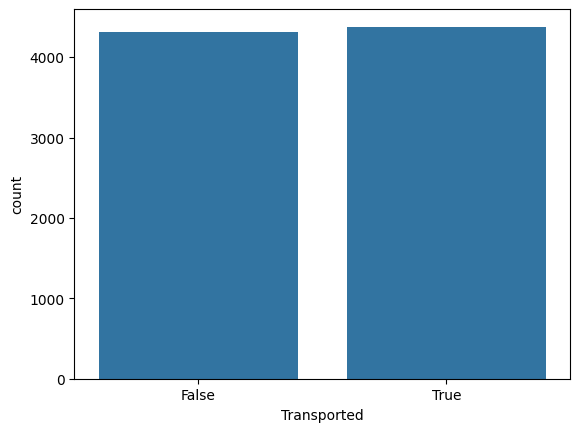

In [13]:
sns.countplot(data=df, x="Transported");

# Observations:
Missing Data and data Types

|Column Name| Missing Value %| dtype|
|:-------|:-------|:-------|
|PassengerId   |  0.000000 | object |
|HomePlanet    |  2.312205 | object|
|CryoSleep     |  0.000000 | object|
|Cabin         |  2.289198 | object|
|Destination   |  2.093639 | object|
|Age           |  2.059128 | Float|
|VIP           |  0.000000 | object|
|RoomService   |  2.082135 | Float|
|FoodCourt     |  2.105142 | Float|
|ShoppingMall  |  2.392730 | Float|
|Spa           |  2.105142 | Float|
|VRDeck        |  2.162660 | Float|
|Name          |  2.300702 | object|
|Transported   |  0.000000 | bool|


# Exploratory Data Analysis

## Target distribution

Text(0.5, 1.0, 'Transported Distribution')

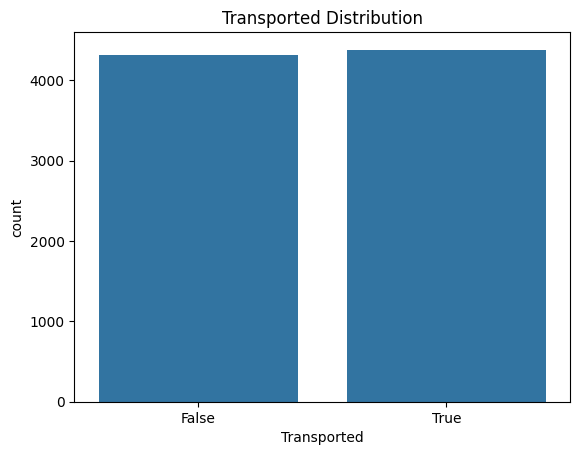

In [41]:
sns.countplot(x='Transported', data=df)
plt.title("Transported Distribution")

## Starting with Bi Variate against target

In [42]:
pd.crosstab(df['CryoSleep'], df['Transported'], normalize='index')


Transported,False,True
CryoSleep,,
False,0.671079,0.328921
True,0.204364,0.795636


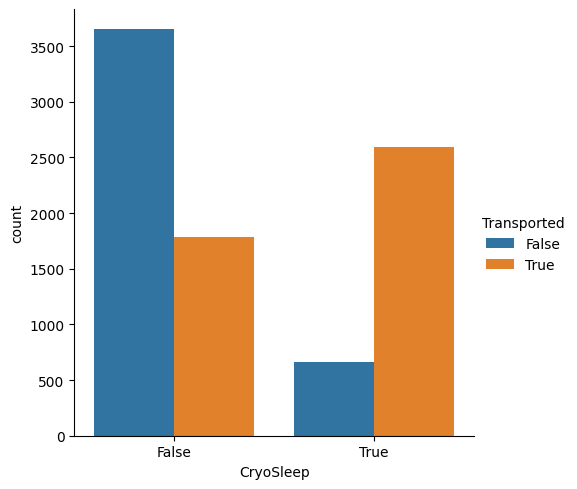

In [43]:
sns.catplot(x='CryoSleep', hue='Transported', kind='count', data=df)

### Observation: Cyrosleep increases chances of being transported

-------------------------------------------------------------------------

## Lets Merge all spendings

In [30]:
spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
df['TotalSpending'] = df[spend_cols].sum(axis=1)

<Axes: xlabel='Transported', ylabel='TotalSpending'>

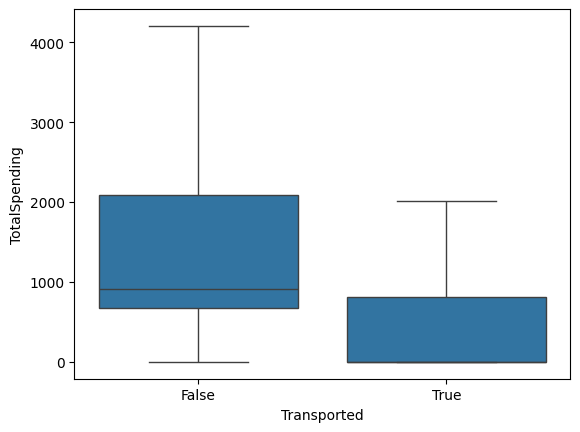

In [32]:
sns.boxplot(x='Transported', y='TotalSpending', data=df, showfliers=False)  # zoom in


## Observation : Most transported are having spending 0, correlate with cryosleep

<Axes: xlabel='TotalSpending', ylabel='Count'>

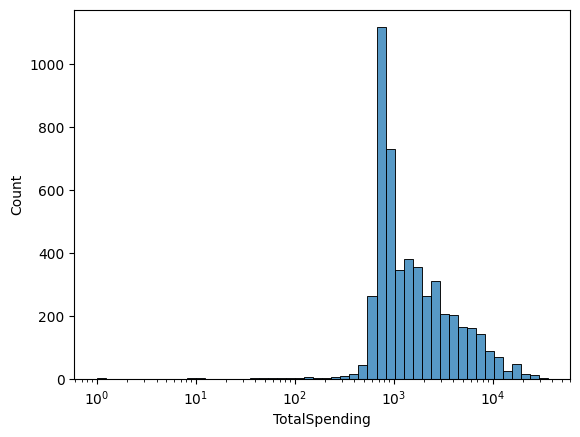

In [33]:
sns.histplot(df['TotalSpending'], bins=50, log_scale=True)  # many zeros

<Axes: xlabel='Transported', ylabel='Age'>

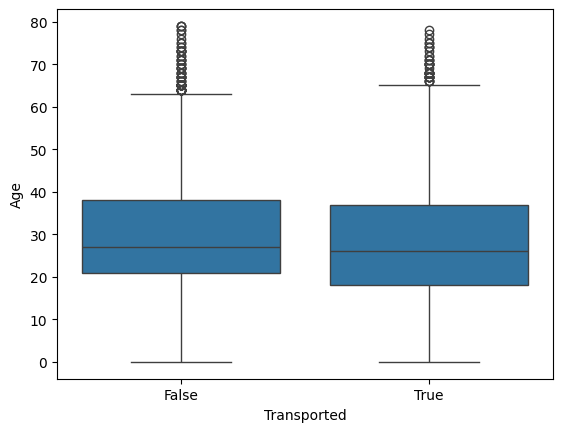

In [34]:
sns.boxplot(x='Transported', y='Age', data=df)

<Axes: xlabel='Age', ylabel='Count'>

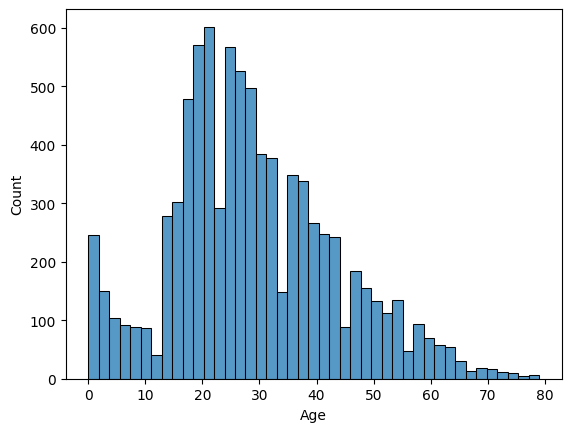

In [80]:
sns.histplot(data=df, x='Age')

<Axes: xlabel='Age', ylabel='Density'>

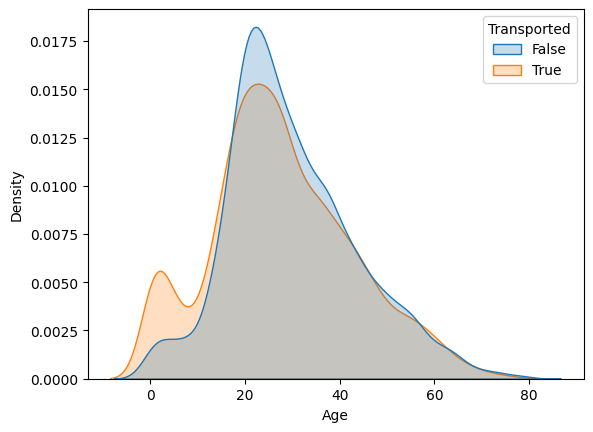

In [35]:
sns.kdeplot(data=df, x='Age', hue='Transported', fill=True)

## Observation : seems transported and transported have similar distribution, but there is a spike where most kids and youngsters are transported


________________________________________________________________________________________________________________________

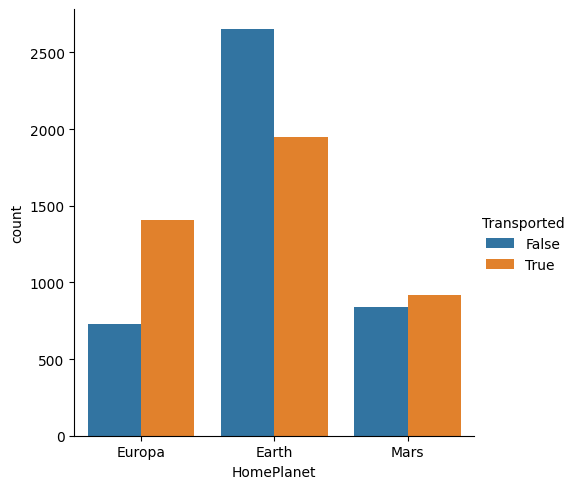

In [36]:
sns.catplot(x='HomePlanet', hue='Transported', kind='count', data=df)

In [37]:
pd.crosstab(df['HomePlanet'], df['Transported'], normalize='index')

Transported,False,True
HomePlanet,,
Earth,0.576054,0.423946
Europa,0.341154,0.658846
Mars,0.476976,0.523024


## Observation : people from Europa have been transported more

In [38]:
df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

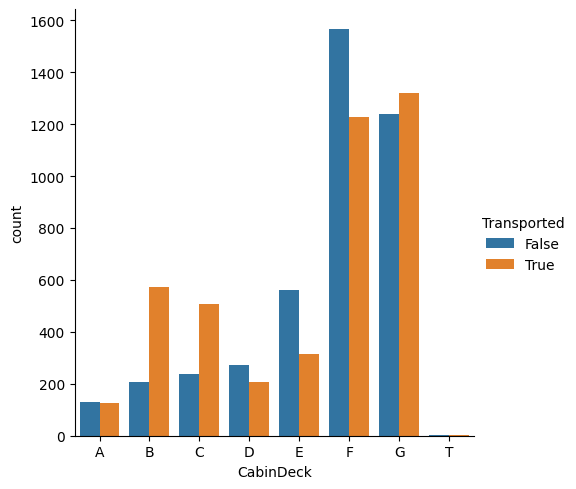

In [39]:
sns.catplot(x='CabinDeck', hue='Transported', kind='count', data=df, order=sorted(df['CabinDeck'].dropna().unique()))

## Observation : seems B and C have higher tranported chances

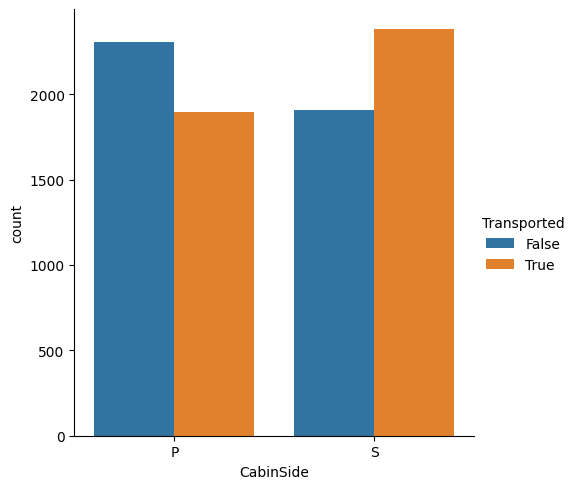

In [40]:
sns.catplot(x='CabinSide', hue='Transported', kind='count', data=df)

## Observation: S side have higher chances of being transported

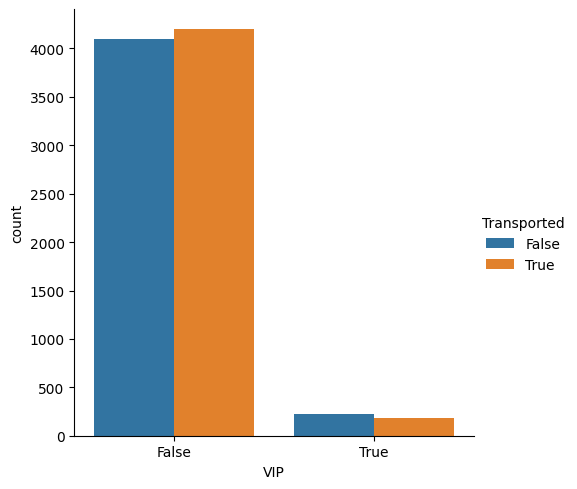

In [46]:
sns.catplot(x='VIP', hue='Transported', kind='count', data=df)

## Observation: seems the most transported are not VIPs and may be 50 % of VIPs are transported

In [47]:
df[['Group','PassengerNum']] = df['PassengerId'].str.split('_', expand=True)

df['Group'] = pd.to_numeric(df['Group'], errors='coerce')
df['PassengerNum'] = pd.to_numeric(df['PassengerNum'], errors='coerce')

In [81]:
group_sizes = df['Group'].value_counts().reset_index()
group_sizes.columns = ['Group', 'GroupSize']

In [82]:
df = df.merge(group_sizes, on='Group', how='left')

In [83]:
print(df[['PassengerId', 'Group', 'PassengerNum', 'GroupSize', 'Transported']].head(10))
print("\nGroupSize distribution:")
print(df['GroupSize'].value_counts().sort_index())

  PassengerId  Group  PassengerNum  GroupSize  Transported
0     0001_01      1             1          1        False
1     0002_01      2             1          1         True
2     0003_01      3             1          2        False
3     0003_02      3             2          2        False
4     0004_01      4             1          1         True
5     0005_01      5             1          1         True
6     0006_01      6             1          2         True
7     0006_02      6             2          2         True
8     0007_01      7             1          1         True
9     0008_01      8             1          3         True

GroupSize distribution:
GroupSize
1    4805
2    1682
3    1020
4     412
5     265
6     174
7     231
8     104
Name: count, dtype: int64


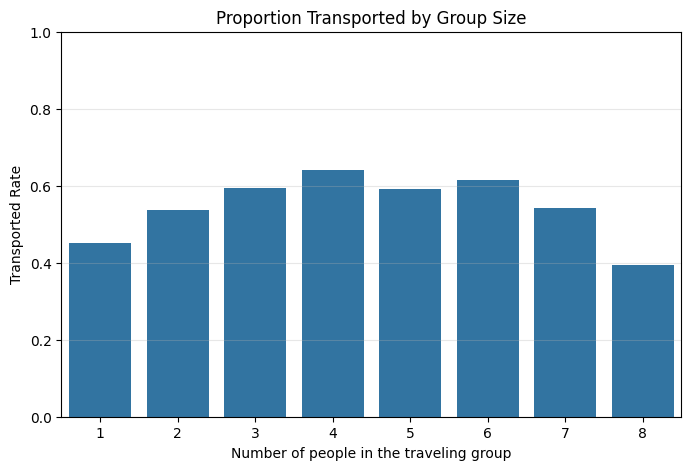

   GroupSize  Transported
0          1     0.452445
1          2     0.538050
2          3     0.593137
3          4     0.640777
4          5     0.592453
5          6     0.614943
6          7     0.541126
7          8     0.394231


In [84]:
# Bar plot with proportions
transported_by_size = df.groupby('GroupSize')['Transported'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='GroupSize', y='Transported', data=transported_by_size)
plt.title("Proportion Transported by Group Size")
plt.ylabel("Transported Rate")
plt.xlabel("Number of people in the traveling group")
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Also print numbers
print(transported_by_size)

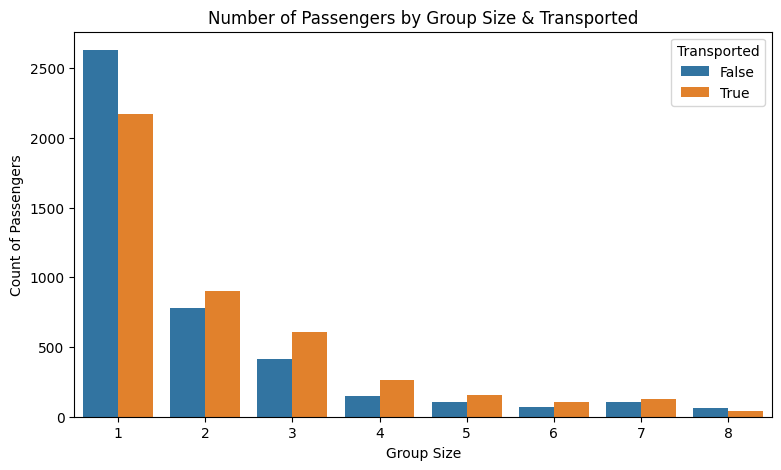

In [85]:
plt.figure(figsize=(9,5))
sns.countplot(x='GroupSize', hue='Transported', data=df)
plt.title("Number of Passengers by Group Size & Transported")
plt.xlabel("Group Size")
plt.ylabel("Count of Passengers")
plt.show()

Transported     False     True 
IsSolo                         
False        0.433128  0.566872
True         0.547555  0.452445


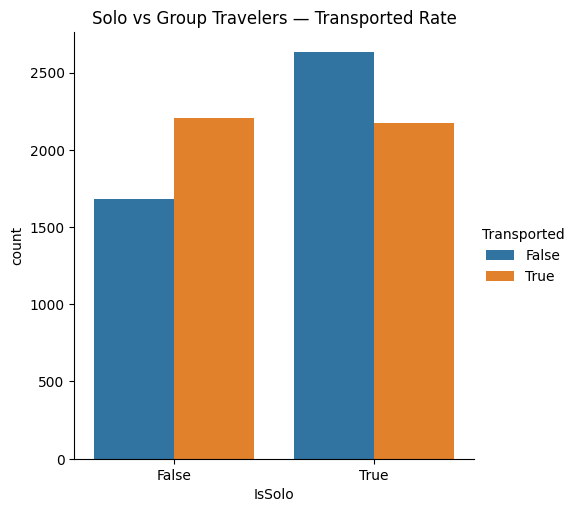

In [86]:
df['IsSolo'] = df['GroupSize'] == 1

# Quick crosstab
print(pd.crosstab(df['IsSolo'], df['Transported'], normalize='index'))

# Plot
sns.catplot(x='IsSolo', hue='Transported', kind='count', data=df)
plt.title("Solo vs Group Travelers — Transported Rate")
plt.show()

## Observation
Passengers traveling in small-to-medium groups (especially size 3–6) are noticeably more likely to be transported (nearly 59–64%) compared to solo travelers (nearly 45%).
Very large groups (8+) and solo travelers appear less affected — possibly because they are assigned to different cabin sections or behaved differently during the anomaly.


GroupSize is a useful predictor. We should include it (or IsSolo + maybe dummies for size 3–6) in our model.